In [1]:
import os
import re
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

import gdal
from affine import Affine
from osgeo import osr
from shapely import wkt, Polygon, bounds

np.set_printoptions(threshold=sys.maxsize) # to display the entire array

In [2]:
# Rasdaman
from rasdapy.db_connector import DBConnector
from rasdapy.query_executor import QueryExecutor

db_connector = DBConnector("localhost", 7001, "rasadmin", "rasadmin")
query_executor = QueryExecutor(db_connector)
db_connector.open() # connection open

if db_connector is not None:
    print("RasDaMan is running") 
    
def restart_rasdaman():
    from rasdapy.db_connector import DBConnector
    from rasdapy.query_executor import QueryExecutor

    db_connector = DBConnector("localhost", 7001, "rasadmin", "rasadmin")
    query_executor = QueryExecutor(db_connector)
    db_connector.open() # connection open

RasDaMan is running


In [3]:
collection_list = query_executor.execute_read("select c from RAS_COLLECTIONNAMES as c")
collection_list = list(collection_list)
collection_list

['AIR_TEMP_X',
 'LST_03_GeoTIFF_FLIPPED',
 'LST_03_GeoTIFF_FLIPPED_CRS',
 'Surface_Temperature_Sweden',
 'South_Tyrol_Temperature_MODIS_1km',
 'Bavaria_Temperature_MODIS_1km',
 'Bavaria_NDVI_250m',
 'Winter_in_sweden1',
 'Munich_Temperature_MODIS_1km',
 'Munich_SRTM_NC_Elevation',
 'Munich_MODIS_SnowCover',
 'Munich_MODIS_NDVI_16uom',
 'Munich_MODIS_NDVI_16XXX',
 'Munich_ECOSTRESS_SoilMoisture_70m']

In [4]:
def grid2WKT_polygon(long_array, lat_array):
    """Create the polygon geometry with requires at least 2 pairs of long, lat coordinates."""
    polygon = Polygon(zip(long_array, lat_array))
    return polygon.wkt

def grid2WKT_ring(long_array, lat_array):
    """Create the linearring geometry with requires at least 2 pairs of long, lat coordinates."""
#     coordinates = list(zip(long_array, lat_array))
#     ring_wkt = "LINEARRING(" + ", ".join(f"{x} {y}" for x, y in coordinates) + ")"
    ring_wkt = LinearRing(zip(long_array, lat_array))
    return ring_wkt
  
def geo2grid(lons, lats, xmin, ymax, pixel_size, xskew = 0.0, yskew = 0.0):
    """ Translate geo indices to grid indices """
    # Geotransform object
    aff_gdal = Affine.from_gdal(xmin, pixel_size, xskew, ymax, yskew, -pixel_size)
    # coordinate data
    lons = np.array(lons)
    lats = np.array(lats)
    xs, ys = ~aff_gdal*(lons, lats)
    xs = np.int64(xs)
    ys = np.int64(ys)

    return xs, ys 

def add_closing_coordinates(d):
    d = str(d)
    """ Adds the first 'lat long' to the end"""
    i = re.search(r"\d", d).start()
    j = re.search(r'(\d)[^\d]*$', d).start() + 1
    c = d.index(',')    
    return d[:j] + ", " + d[i:c] + d[j:]

def processRING(ring):
    lat_arr = []
    long_arr = []
    if ring.is_closed == True:
        # Extract longitudes and latitudes
        longitudes, latitudes = zip(ring.xy)
        
        for i in range(len(latitudes[0])):
            long_arr = np.append(long_arr, longitudes[0][i])
            lat_arr = np.append(lat_arr, latitudes[0][i])

        long_list = long_arr.tolist()
        lat_list = lat_arr.tolist()

        x_grid, y_grid = geo2grid(long_list, lat_list, xmin, ymax, pixel_size)
        gridRING_yx = grid2WKT_ring(y_grid, x_grid)

        return gridRING_yx
    else:
        print("Incomplete ring")

        
def processPOLYGON(inputPOLYGON, regionID = None):
    if len(inputPOLYGON.interiors) == 0:
        polygon = wkt.loads(add_closing_coordinates(inputPOLYGON))
        coords = np.dstack(polygon.boundary.xy).tolist()[0][:-1]
        expected_list_of_coordinates_for_received_code = [{"long": x, "lat": y} for x, y in coords]
        lat_arr = []
        long_arr = []
        for i in range(len(expected_list_of_coordinates_for_received_code)):
            long_arr = np.append(long_arr, expected_list_of_coordinates_for_received_code[i]['long'])
            lat_arr = np.append(lat_arr, expected_list_of_coordinates_for_received_code[i]['lat'])

        long_list = long_arr.tolist()
        lat_list = lat_arr.tolist()

        x_grid, y_grid = geo2grid(long_list, lat_list, xmin, ymax, pixel_size)
        gridPOLYGON_yx = grid2WKT_polygon(y_grid, x_grid)

        return gridPOLYGON_yx
    else:
        print(f"{regionID}: \x1b[1;31m{len(inputPOLYGON.interiors)}\x1b[0m Polygon Rings Detected")
        mainPOLYGON = Polygon(inputPOLYGON.exterior)  # Convert main ring to main polygon without inner ring
        gridPOLYGON_yx = wkt.loads(processPOLYGON(mainPOLYGON))
        
        linear_rings_array = []

        for ring in range(len(inputPOLYGON.interiors)):
            gridRING = processRING(inputPOLYGON.interiors[ring])
            linear_rings_array.append(gridRING)
            
        gridPOLYGON_WITH_HOLE_yx = Polygon(gridPOLYGON_yx.exterior, linear_rings_array)
        print(f"{regionID}: \x1b[1;31m{len(inputPOLYGON.interiors)}\x1b[0m Polygons are Processed")
        
        return gridPOLYGON_WITH_HOLE_yx #return gridPOLYGON_yx_assembled
    
def geoPOLYGON_to_gridPOLYGON_03(inputREGION, regionID = None):
    polygons_array1 = []
    polygons_array2 = []
    i = 0
    r = 0
    if inputREGION.geom_type == 'Polygon':
        print(f"{regionID}: Polygon is processing")
        return processPOLYGON(inputREGION, regionID)
    
    elif len(list(inputREGION.geoms[0].interiors)) > 0:    # MultiPolygon with atleast 1 inner rings
        print(f"{regionID}: MultiPolygon has Inner Rings")        
        for polygon in inputREGION.geoms:
            gridPOLYGON = processPOLYGON(polygon)
            polygons_array1.append(gridPOLYGON)
            r = r +1
            
        gridMULTI =  [wkt.loads(poly) for poly in polygons_array1]
        return shapely.geometry.MultiPolygon(gridMULTI)

    else:                                                  # MultiPolygon with 0 rings
        print(f"{regionID}: MultiPolygon is processing")
        for polygon in inputREGION.geoms:
            gridPOLYGON = processPOLYGON(polygon)
            polygons_array2.append(gridPOLYGON)
            i = i +1
            #print(f"flag {i}") # i th inner polygon
            
        gridMULTI =  [wkt.loads(poly) for poly in polygons_array2]
        return shapely.geometry.MultiPolygon(unary_union(gridMULTI))


######## RasDaMan F(X) ##############################################################################################
################################################################################################################

def query2array2visuallize(query, title=None, fill_val=None):
    result = query_executor.execute_read(query) 
    # array conversion and cleaning
    numpy_array = result.to_array()
    if fill_val is not None:
        numpy_array = numpy_array.astype('float')
        numpy_array[numpy_array == (fill_val)] = 'nan'
        data = numpy_array
    else:
        # Data for the heat map
        data = numpy_array
    # Function to show the heat map
    ax = sns.heatmap(data , cmap = 'Spectral_r')
    # Adding details to the plot
    plt.rcParams["figure.figsize"]=(7,5)
    plt.title(title)
    plt.xlabel('x-axis (Longitude)')
    plt.ylabel('y-axis (Latitude)')
    # Displaying the plot
    plt.show()
    return True #return numpy_array   

def query2array(query, fill_val=None):
    result = query_executor.execute_read(query) 
    # array conversion and cleaning
    numpy_array = result.to_array()
    if fill_val is not None:
        numpy_array = numpy_array.astype('float')
        numpy_array[numpy_array == fill_val] = 'nan'
        return numpy_array
    else:
        return numpy_array
    
def query2numeric(query):
    result = query_executor.execute_read(query) 
    return float("{}".format(result))

def query2result(query):
    result = query_executor.execute_read(query) 
    print(result)
    return result

def query2tiff(query, fill_val=None):
    result = query_executor.execute_read(query) 
    # array conversion and cleaning
    numpy_array = result.to_array()
    if fill_val is not None:
        numpy_array = numpy_array.astype('float')
        numpy_array[numpy_array == fill_val] = 'nan'
        return numpy_array
    else:
        return numpy_array

In [5]:
gdfDist25 = gpd.read_file('/home/arkaghosh/Downloads/MunichCity/VectorData/Munich_25_Bezirke_Dissolved.shp')
gdfSubDist105 = gpd.read_file('/home/arkaghosh/Downloads/MunichCity/VectorData/Munich_105_Bezirke.shp')

In [6]:
raster01_path = '/home/arkaghosh/Downloads/MunichCity/RasterData/SRTMGL1_NC.003_30m_aid0001.nc'
raster02_path = '/home/arkaghosh/Downloads/MunichCity/RasterData/MOD11A1.061_1km_aid0001.nc'
raster03_path = '/home/arkaghosh/Downloads/MunichCity/RasterData/MOD13Q1.061_250m_aid0001.nc'
raster04_path = '/home/arkaghosh/Downloads/MunichCity/RasterData/ECO_L3T_SM.002_70m_aid0001_32N.nc'

In [7]:
### FOR SRTM DEM DATA
f = xr.open_dataset(raster01_path)
lons = f['lon'].values
lats = f['lat'].values
dem = f['SRTMGL1_DEM'].values
pixel_size =  0.0002777777777779992

In [8]:
xmax = float(f['lon'].max())
xmin = float(f['lon'].min())
ymin = float(f['lat'].min())
ymax = float(f['lat'].max())

In [9]:
xmin, xmax, ymin, ymax

(11.360833333342422, 11.723055555564933, 48.06166666670512, 48.248055555594156)

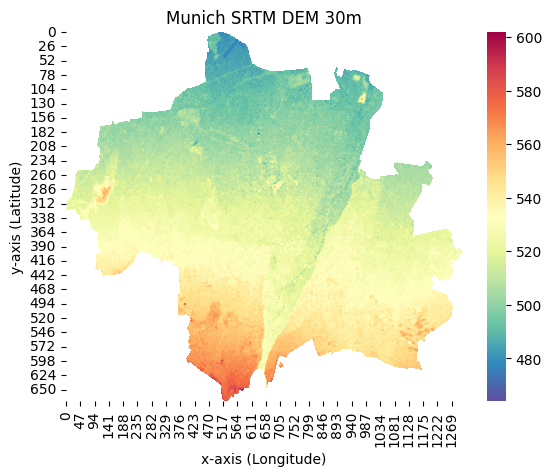

True

In [10]:
q = "select datacube[0, 0:* , 0:*] from Munich_SRTM_NC_Elevation as datacube" #100, 178
query2array2visuallize(q, "Munich SRTM DEM 30m", -32768) # FILL VAL = -32768 (from gdalinfo)

In [11]:
gid = 66 # Total 105 subdistricts
print(gdfSubDist105.NAME[gid],'of', gdfSubDist105.Bezirk[gid])
INPUT = gdfSubDist105.geometry[gid]

Graggenau of Altstadt-Lehel


In [12]:
qARRAY = 'select clip(m[0, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Munich_SRTM_NC_Elevation as m'

66: Polygon is processing


In [13]:
qARRAY

'select clip(m[0, 0:* , 0:*],POLYGON ((399 774, 399 776, 396 778, 392 779, 390 780, 387 779, 385 779, 382 780, 380 780, 383 800, 386 801, 391 806, 393 805, 403 803, 404 802, 407 796, 407 793, 407 785, 403 786, 401 780, 399 774))) from Munich_SRTM_NC_Elevation as m'

## query2folium

In [17]:
from matplotlib.colors import Normalize
import rasterio
import folium

In [18]:
def get_polygon_extent(polygon):
    coords = list(polygon.exterior.coords)
    xs = [x for x, y in coords]
    ys = [y for x, y in coords]
    return [min(xs), min(ys), max(xs), max(ys)]

def getGeoTransform(extent, nlines, ncols):
    resx = (extent[2] - extent[0]) / ncols
    resy = (extent[3] - extent[1]) / nlines
    return [extent[0], resx, 0, extent[3] , 0, -resy]

def query2folium(query, INPUT, filename = None, fill_val=None):
    result = query_executor.execute_read(query) 
    # array conversion and cleaning
    numpy_array = result.to_array()
    if fill_val is not None:
        numpy_array = numpy_array.astype('float')
        numpy_array[numpy_array == fill_val] = 'nan'
    
    driver = gdal.GetDriverByName('GTiff')  # Get GDAL driver GeoTiff
    extent = bounds(INPUT).tolist()
    # Get dimensions
    nrows = numpy_array.shape[0]
    ncols = numpy_array.shape[1]
    nbands = len(numpy_array.shape)
    data_type = gdal.GDT_Float32
    # Create a temp grid
    #options = ['COMPRESS=JPEG', 'JPEG_QUALITY=80', 'TILED=YES']
    grid_data = driver.Create('grid_data', ncols, nrows, 1, data_type)#, options) driver.Create(path, cols, rows, bands, dtype)

    # Write data for each bands
    grid_data.GetRasterBand(1).WriteArray(numpy_array)

    # Lat/Lon WSG84 Spatial Reference System
    srs = osr.SpatialReference()
    srs.ImportFromProj4('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')

    # Setup projection and geo-transform
    grid_data.SetProjection(srs.ExportToWkt())
    grid_data.SetGeoTransform(getGeoTransform(extent, nrows, ncols))

    # Save the file
    file_name = str(filename)+'.tif'
    print(f'Generated GeoTIFF: {file_name}')
    driver.CreateCopy(file_name, grid_data, 0)  

    # Close the file
    driver = None
    grid_data = None

    # Delete the temp grid            
    os.remove('grid_data')
    # Enter Folium
    elevRaster = rasterio.open(file_name)
    elevArray = elevRaster.read(1)

    boundList = [x for x in elevRaster.bounds]

    # Normalize the data for colormap application
    norm = Normalize(vmin=np.nanmin(elevArray), vmax=np.nanmax(elevArray))

    # Create a colormap (e.g., jet)
    cmap = plt.cm.get_cmap('jet')

    # Function to apply colormap
    def colormap_function(x):
        rgba = cmap(norm(x))  # Apply normalization and colormap
        return (rgba[0], rgba[1], rgba[2], rgba[3])  # Return RGBA

    rasLon = (boundList[3] + boundList[1])/2
    rasLat = (boundList[2] + boundList[0])/2
    mapCenter = [rasLon, rasLat]

    # (tiles=Cartodb dark_matter, Cartodb Positron, OpenStreetMap)
    mf = folium.Map(location=mapCenter, tiles="Cartodb Positron", zoom_start=13)
    folium.raster_layers.ImageOverlay(
        image=elevArray,
        bounds=[[boundList[1], boundList[0]], [boundList[3], boundList[2]]],
        opacity=0.52,
        colormap=colormap_function,  # Apply the colormap function
        interactive=True,
        cross_origin=False,
    ).add_to(mf)
    
    print('\n',mf)
    
    return mf

In [19]:
query2folium(qARRAY, INPUT, 'OUTPUT', -32768)

Generated GeoTIFF: OUTPUT.tif



In [20]:
import glob

path = r'*.tif'
geotiff_files = glob.glob(path)
print(geotiff_files)

['Aubing-Süd.tif', 'Berg am Laim.tif', 'Neupasing.tif', 'Gartenstadt Trudering.tif', 'Steinhausen.tif', 'Obersendling.tif', 'Am Westbad.tif', 'St. Paul.tif', 'Neuhausen.tif', 'Forstenried.tif', 'Fürstenried-West.tif', 'Josephsplatz.tif', 'Dreimühlen.tif', 'Ramersdorf.tif', 'Parkstadt.tif', 'Land in Sonne.tif', 'Haidhausen - Nord.tif', 'Angerviertel.tif', 'Am alten südlichen Friedhof.tif', 'Glockenbach.tif', 'Hackenviertel.tif', 'Balanstraße-West.tif', 'Schwabing - Ost.tif', 'Marsfeld.tif', 'Am Schlachthof.tif', 'OUTPUT.tif', 'Englschalking.tif', 'Trudering - Riem.tif', 'Maßmannbergl.tif', 'Sendlinger Feld.tif', 'Blumenau.tif', 'Friedenheim.tif', 'Waldtrudering.tif', 'Pasing.tif', 'St. Ulrich.tif', 'Neuhadern.tif', 'Haidhausen - Süd.tif', 'Untersendling.tif', 'Harlaching.tif', 'Gärtnerplatz.tif', 'Am Waldfriedhof.tif', 'Thalkirchen.tif', 'Neuperlach.tif', 'Augustenstraße.tif', 'Westend.tif', 'Großhadern.tif', 'Altaubing.tif', 'Nymphenburg.tif', 'Waldperlach.tif', 'Messestadt Riem.tif', 

In [21]:
import random

chosen_geotiff = random.sample(geotiff_files, 10)
print(chosen_geotiff)

['St. Ulrich.tif', 'Altperlach.tif', 'Balanstraße-West.tif', 'Neuhausen.tif', 'Haidhausen - Süd.tif', 'Neupasing.tif', 'Angerviertel.tif', 'Ramersdorf.tif', 'Sendlinger Feld.tif', 'Obersendling.tif']



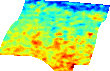
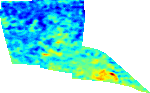
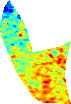
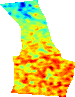
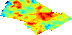
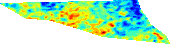
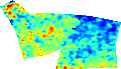
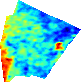
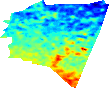

In [22]:
# Initialize the folium map (tiles=Cartodb dark_matter, Cartodb Positron, OpenStreetMap)
m7 = folium.Map(location=[48.140127502683185, 11.564962856463069], tiles="Cartodb Positron", zoom_start=12)

# Create a colormap (e.g., jet)
cmap = plt.cm.get_cmap("jet")

# Open each GeoTIFF in the list
for geotiff in chosen_geotiff:
    with rasterio.open(geotiff) as src:
        data = src.read(1)  # Read the first band
        bounds = src.bounds

        norm = Normalize(vmin=np.nanmin(data), vmax=np.nanmax(data))

        # Function to apply colormap
        def colormap_function(x):
            rgba = cmap(norm(x))  # Apply normalization and colormap
            return (rgba[0], rgba[1], rgba[2], rgba[3])  # Return RGBA

        # Convert bounds to lat/lon for overlay
        west, south, east, north = bounds
        folium.raster_layers.ImageOverlay(
            image=data,
            bounds=[[south, west], [north, east]],
            opacity=0.52,
            colormap=colormap_function,  # Apply the colormap function
            interactive=True,
            cross_origin=False,
        ).add_to(m7)

## TO PLOT VECTOR DATA

# style_function = lambda x: {
#     'color' : "black",
#     'weight' : 2,
#     'opacity':1,
#     'fillColor' : "white"
# }

# for _, r in gdfSubDist105.iterrows():
#     # Without simplifying the representation of each borough, the map might not be displayed
#     sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.000001)
#     geo_j = sim_geo.to_json()
#     geo_j = folium.GeoJson(data=geo_j, style_function=style_function)
#     folium.Popup(r["NAME"]).add_to(geo_j)
#     geo_j.add_to(m6)

# m6.save("OUTPUTMAP.html")
print(m7)
m7